In [1]:
import cv2  # openCV
import os

# Data manipulation & visulation
import numpy as np
import pandas as pd
%matplotlib inline
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import seaborn as sns
import tensorflow as tf
import keras.backend as K


from keras.preprocessing.image import ImageDataGenerator
from keras.callbacks import LearningRateScheduler
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from tensorflow import keras
from keras.layers import Dense, Dropout, Activation, Flatten
from keras.layers import Conv2D, MaxPooling2D, Dropout, BatchNormalization
from tensorflow.keras.utils import to_categorical    # one hot encoding
from tensorflow.keras.optimizers import SGD,Adam
from keras.utils import np_utils
from google.colab.patches import cv2_imshow
from keras.models import Sequential

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
%cd /content/drive/MyDrive/MachineLearning/VN_Food

/content/drive/MyDrive/MachineLearning/VN_Food


In [ ]:
root_dir = '/content/drive/MyDrive/MachineLearning/VN_Food'

In [ ]:
X = []
y = []

In [ ]:
def make_set(food_name):
    for i in range(len(os.listdir(os.path.join(root_dir,food_name)))):
        img = mpimg.imread(os.path.join(root_dir,food_name,os.listdir(os.path.join(root_dir,food_name))[i]))
        img = cv2.resize(img,(128,128))
        X.append(img)
        y.append(food_name)
    return X,y

In [ ]:
X,y = make_set('banh_beo')
X,y = make_set('banh_trang_tron')
X,y = make_set('bun_cha')
X,y = make_set('chuoi_chien')
X,y = make_set('sup_cua')

In [ ]:
X = np.array(X)
y = np.array(y)

In [ ]:
print(X.shape)
print(y.shape)

(2323, 128, 128, 3)
(2323,)


/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


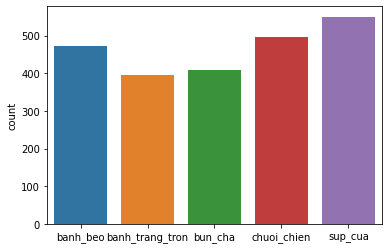

In [ ]:
sns.countplot(y)

In [ ]:
X = X/255 #chuan hoa du lieu
#y hiện đang là dữ liệu định danh
le = LabelEncoder()
y = le.fit_transform(y) #ánh xạ về giá trị số 0, 1, 2, 3,4
y = to_categorical(y, 5)  #Converts a class vector (integers) to binary class matrix.


In [ ]:
y[900]

array([0., 0., 1., 0., 0.], dtype=float32)

In [ ]:
datagen = ImageDataGenerator(featurewise_center= False,
                              samplewise_center= False,
                              featurewise_std_normalization= False,
                              samplewise_std_normalization=False,
                              rotation_range= 10,        # 0- 180
                              zca_whitening=False,
                              zoom_range=0.1,            # Randomly zoom image
                              width_shift_range=0.2,     # randomly shift images horizontally (fraction of total width)
                              height_shift_range=0.2,    # randomly shift images vertically (fraction of total height)
                              horizontal_flip=True,      # randomly flip images
                              vertical_flip=False)       # randomly flip images

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [ ]:
datagen.fit(X_train)

In [ ]:
from tensorflow.keras.applications.vgg16 import VGG16

In [ ]:
model = VGG16(input_shape = (128, 128, 3), 
                                include_top = False, 
                                weights = 'imagenet',
                                pooling='avg')

58889256/58889256 [==============================] - 2s 0us/step


In [ ]:
model.summary()

Model: "vgg16"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 128, 128, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 128, 128, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 128, 128, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 64, 64, 64)        0         
                                                                 
 block2_conv1 (Conv2D)       (None, 64, 64, 128)       73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 64, 64, 128)       147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 32, 32, 128)       0     

In [ ]:
vgg16_model = Sequential()
vgg16_model.add(model)
vgg16_model.add(Dense(4096,activation='relu'))
vgg16_model.add(Dense(4096,activation='relu'))
vgg16_model.add(Dense(5,activation='softmax'))

vgg16_model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 vgg16 (Functional)          (None, 512)               14714688  
                                                                 
 dense (Dense)               (None, 4096)              2101248   
                                                                 
 dense_1 (Dense)             (None, 4096)              16781312  
                                                                 
 dense_2 (Dense)             (None, 5)                 20485     
                                                                 
Total params: 33,617,733
Trainable params: 33,617,733
Non-trainable params: 0
_________________________________________________________________


In [ ]:
model.trainable=False

In [ ]:
vgg16_model.compile(optimizer='adam', loss= 'categorical_crossentropy', metrics=['accuracy'])

In [ ]:
batch_size=64
hist = vgg16_model.fit_generator(datagen.flow(X_train,y_train, batch_size=batch_size),
                              epochs = 100, validation_data = datagen.flow(X_test,y_test),
                              verbose = 1, steps_per_epoch=X_train.shape[0] // batch_size)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:4: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  after removing the cwd from sys.path.


Epoch 1/100
29/29 [==============================] - 22s 424ms/step - loss: 1.7735 - accuracy: 0.5312 - val_loss: 0.8671 - val_accuracy: 0.6667
Epoch 2/100
29/29 [==============================] - 10s 353ms/step - loss: 0.7312 - accuracy: 0.7163 - val_loss: 0.7270 - val_accuracy: 0.7269
Epoch 3/100
29/29 [==============================] - 9s 321ms/step - loss: 0.5882 - accuracy: 0.7823 - val_loss: 0.6436 - val_accuracy: 0.7419
Epoch 4/100
29/29 [==============================] - 9s 318ms/step - loss: 0.5434 - accuracy: 0.7949 - val_loss: 0.9206 - val_accuracy: 0.6624
Epoch 5/100
29/29 [==============================] - 9s 319ms/step - loss: 0.5640 - accuracy: 0.7832 - val_loss: 0.6655 - val_accuracy: 0.7527
Epoch 6/100
29/29 [==============================] - 9s 320ms/step - loss: 0.5025 - accuracy: 0.8116 - val_loss: 0.6355 - val_accuracy: 0.7634
Epoch 7/100
29/29 [==============================] - 9s 323ms/step - loss: 0.4380 - accuracy: 0.8378 - val_loss: 0.6815 - val_accuracy: 0.74

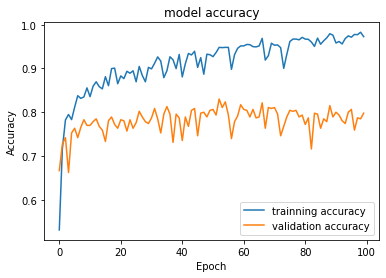

In [ ]:
import matplotlib.pyplot as plt
plt.plot(hist.history["accuracy"])
plt.plot(hist.history["val_accuracy"])

plt.title("model accuracy")
plt.ylabel("Accuracy")
plt.xlabel("Epoch")
plt.legend(["trainning accuracy","validation accuracy"])
plt.show()

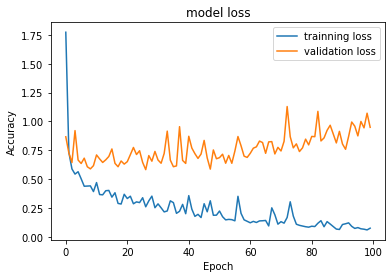

In [ ]:
import matplotlib.pyplot as plt
plt.plot(hist.history["loss"])
plt.plot(hist.history["val_loss"])

plt.title("model loss")
plt.ylabel("Accuracy")
plt.xlabel("Epoch")
plt.legend(["trainning loss","validation loss"])
plt.show()

In [ ]:
Pred = vgg16_model.predict(X_test)

15/15 [==============================] - 1s 53ms/step


In [ ]:
from sklearn.metrics import accuracy_score
print("Accuracy is: ", accuracy_score(y_test, Pred.round())*100)

Accuracy is:  81.0752688172043


X,y = make_set('banh_beo')
X,y = make_set('banh_trang_tron')
X,y = make_set('bun_cha')
X,y = make_set('chuoi_chien')
X,y = make_set('sup_cua')



In [4]:
from tensorflow.keras.preprocessing.image import load_img , img_to_array
from tensorflow import keras

In [7]:
classes = ['banh_beo','banh_trang_tron','bun_cha','chuoi_chien','sup_cua']
img = load_img("/content/drive/MyDrive/MachineLearning/banhtrangtron.jpg", target_size = (128 , 128))
img = img_to_array(img)
img = img.reshape(1 , 128 ,128 ,3)

img = img.astype('float32')
img = img/255.0
vgg16_model = keras.models.load_model('/content/drive/MyDrive/MachineLearning/VN_Food/vgg16_v2.hdf5')
result = vgg16_model.predict(img)
dict_result = {}
for i in range(5):
    dict_result[result[0][i]] = classes[i]

res = result[0]
res.sort()
res = res[::-1]
prob = res[:3]

prob_result = []
class_result = []

for i in range(3):
    prob_result.append((prob[i]*100).round(2))
    class_result.append(dict_result[prob[i]])
predictions = {
      "class1":class_result[0],
      "class2":class_result[1],
      "class3":class_result[2],
      "prob1": prob_result[0],
      "prob2": prob_result[1],
      "prob3": prob_result[2],
}
print(predictions)

1/1 [==============================] - 0s 134ms/step
{'class1': 'sup_cua', 'class2': 'banh_beo', 'class3': 'banh_trang_tron', 'prob1': 58.81, 'prob2': 39.86, 'prob3': 0.91}


In [ ]:
vgg16_model.save("vgg16_v2.hdf5")